## Use phot-griz environment (updated photutils)

In [1]:
# General imports
import os
import numpy as np
import matplotlib.pyplot as plt

# Segmentation
from astropy.io import fits
from photutils.segmentation import SourceFinder, make_2dgaussian_kernel, SourceCatalog
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve
from astropy.wcs import WCS as wcs

# grizli
from grizli.model import GrismFLT
import grizli

os.chdir("/Users/keith/astr/research_astr/summer-roman-project/FOV0_sims/fits")
file_root = "GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits" # Change filename with this variable
direct_file = "ready_direct_{0}".format(file_root)
seg_file = "seg.fits"

In [2]:
# Process direct image and produce segmentation map

# Open image
direct_fits = fits.open(direct_file)
PrimaryHDU = direct_fits[0]
data, header = (direct_fits[1].data, direct_fits[1].header)


# Subtract background
bkg_estimator = MedianBackground()
bkg = Background2D(data, (511,511), filter_size=(3,3), bkg_estimator=bkg_estimator)
data -= bkg.background

# Convolve image
kernel = make_2dgaussian_kernel(3.0, 5)
convolved_data = convolve(data, kernel)

# Instantiate the SourceFinder and set threshold
finder = SourceFinder(npixels=7, nlevels=32, contrast=0.001)
threshold = 2 * bkg.background_rms

seg_map = finder(convolved_data, threshold)

# Save seg_map as fits
fits.writeto(seg_file, seg_map, header=header,overwrite=True)

Deblending:   0%|          | 0/6281 [00:00<?, ?it/s]

In [3]:
# Create Catalog
cat = SourceCatalog(data, seg_map, convolved_data=convolved_data)
cat.add_extra_property('id', np.cast[int](cat.label), overwrite=True)
cat.add_extra_property('x_flt', cat.xcentroid, overwrite=True)
cat.add_extra_property('y_flt', cat.ycentroid, overwrite=True)
mag = -2.5 * np.log10(cat.segment_flux)
cat.add_extra_property('mag', mag, overwrite=True)
ra, dec = wcs(header).all_pix2world(cat.x_flt, cat.y_flt, 1)
cat.add_extra_property('ra', ra, overwrite=True)
cat.add_extra_property('dec', dec, overwrite=True)


columns = ['id', 'ra', 'dec', 'x_flt', 'y_flt', 'mag', 'area', 'semimajor_sigma', 'semiminor_sigma',
           'orientation', 'eccentricity', 'min_value', 'max_value']
tbl = cat.to_table(columns)

# # Uncomment to save catalog
seg_cat = "seg_cat.detect.cat"

if os.path.exists(seg_cat):
            os.remove(seg_cat)
tbl.write(seg_cat, format='ascii.commented_header')

In [4]:
# Instantiate the GrismFLT object
pad = 100
roman_sim = GrismFLT(direct_file=direct_file, seg_file=seg_file, pad=pad)



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation seg.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [5]:
# Read in SED
from astropy.io import fits
SED_data = fits.open("/Users/keith/astr/research_astr/FOV0/SEDs/SED:rest:gal.107381.fits")[1].data

In [6]:
# Extract wavelength and flux
wavelength = np.asarray([(tuple[0]*3) for tuple in SED_data])
flux = np.asarray([tuple[1] for tuple in SED_data])

In [7]:
# Compute Flat vs 1D Spectra
model_orders = roman_sim.compute_model_orders(id=24, compute_size=False, size=77, in_place=False, spectrum_1d=[wavelength, flux])
flat_orders = roman_sim.compute_model_orders(id=24, compute_size=False, size=77, in_place=False)

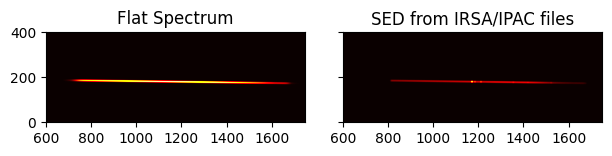

In [8]:
# Display comparison image
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(flat_orders[1], origin="lower", cmap='hot')
ax1.set_xlim(600, 1750)
ax1.set_ylim(0, 400)
ax1.set_title("Flat Spectrum")

ax2.imshow(model_orders[1], origin="lower", cmap='hot')
ax2.set_xlim(600, 1750)
ax2.set_ylim(0, 400)
ax2.set_title("SED from IRSA/IPAC files")
ax2.set_yticklabels([])

fig.tight_layout()

In [9]:
raise Exception("Pause before saving")

Exception: Pause before saving

In [ ]:
ImageHDU = fits.ImageHDU(data=roman_sim.model[pad:-pad, pad:-pad], header=header, name='SCI')
err_HDU = fits.ImageHDU(data=np.zeros_like(roman_sim.model[pad:-pad, pad:-pad]), header=header, name='ERR')
DQ_HDU = fits.ImageHDU(data=np.zeros_like(roman_sim.model[pad:-pad, pad:-pad]), header=header, name='DQ')


hdul = [PrimaryHDU, ImageHDU, err_HDU, DQ_HDU]

fits.HDUList(hdul).writeto("model_slitless_{0}".format(file_root), overwrite=True)